<a href="https://www.kaggle.com/code/fredygerman/carvis-starter-notebook?scriptVersionId=188078001" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# path_ = '../decoded-frames/decoded_can_frames.json' (local)
path_ = '/kaggle/input/carvis-decoded-can-frames/decoded_can_frames.json' 

# Load decoded CAN frames from JSON file
with open(path_, 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.json_normalize(data)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

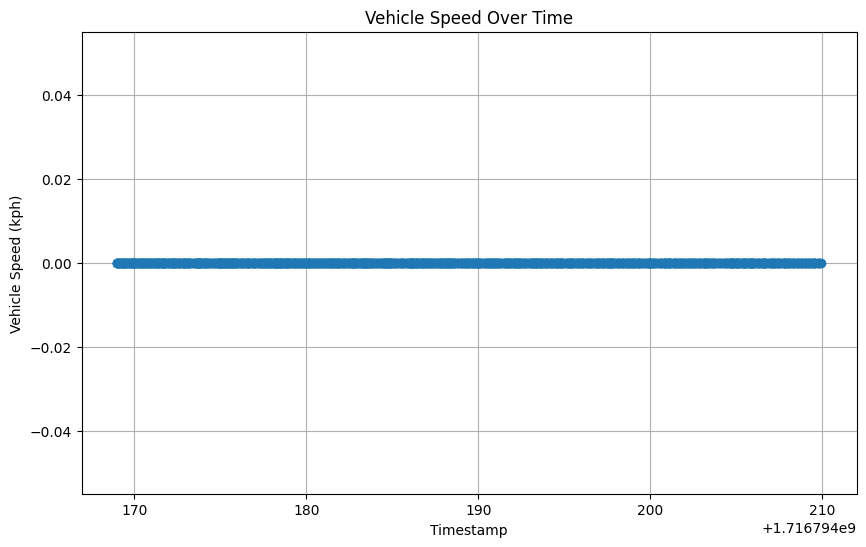

In [2]:

## This example show's why you always need to normalize your data in order to get rid of outliers

# Filter for CAN ID 416 (Speed)
speed_data = [frame for frame in data if frame['can_id'] == 416]

# Define the scaling factor based on DBC
SCALING_FACTOR = 0.103

# Extract VehicleSpeed and find the maximum value
timestamps = []
speeds = []
max_speed = 0.0
has_non_zero_speed = False



for frame in speed_data:
    if 'signals' in frame and 'VehicleSpeed' in frame['signals']:
        speed = frame['signals']['VehicleSpeed']  # Apply scaling factor
        timestamps.append(frame['timestamp'])
        speeds.append(speed)
        # print(f"Time: {frame['timestamp']}, Vehicle Speed: {speed} kph")
        if speed > max_speed:
            max_speed = speed
        if speed > 0:
            has_non_zero_speed = True

if has_non_zero_speed:
    print(f"The highest Vehicle Speed recorded is {max_speed} kph")

# Plot VehicleSpeed over time
if timestamps and speeds:
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, speeds, marker='o')
    plt.xlabel('Timestamp')
    plt.ylabel('Vehicle Speed (kph)')
    plt.title('Vehicle Speed Over Time')
    plt.grid(True)
    plt.show()
else:
    print("No speed data available to plot.")

In [3]:

import numpy as np
import plotly.graph_objects as go


timestamps = []
speeds = []

# Fill 'speeds' and 'timestamps' with relevant data
for frame in speed_data:
    if 'signals' in frame and 'VehicleSpeed' in frame['signals']:
        speed = frame['signals']['VehicleSpeed']
        timestamps.append(frame['timestamp'])
        speeds.append(speed)

# Convert speeds to a numpy array for easy numerical operations
speeds_array = np.array(speeds)


# Calculate IQR
Q1 = np.percentile(speeds_array, 25)
Q3 = np.percentile(speeds_array, 75)
IQR = Q3 - Q1

# Define outlier thresholds
upper_bound = Q3 + 1.75 * IQR
lower_bound = Q1 - 1.75 * IQR

# Convert speeds to a numpy array for easy numerical operations
speeds_array = np.array(speeds)


# Filter outliers
filtered_speeds = speeds_array[speeds_array <= upper_bound]

# Find the highest speed that is not an outlier
max_valid_speed = np.max(filtered_speeds)

print(f"The highest valid Vehicle Speed recorded is {max_valid_speed:.2f} kph")


# Create the interactive plot
fig = go.Figure()

# Add vehicle speed trace
fig.add_trace(go.Scatter(x=timestamps, y=speeds, mode='lines+markers', name='Vehicle Speed', line=dict(color='blue')))

# Add lines for upper and lower outlier bounds
fig.add_shape(
    type="line",
    x0=min(timestamps),
    x1=max(timestamps),
    y0=upper_bound,
    y1=upper_bound,
    line=dict(color="Red", width=2, dash="dashdot"),
    name="Upper Bound"
)
fig.add_shape(
    type="line",
    x0=min(timestamps),
    x1=max(timestamps),
    y0=lower_bound,
    y1=lower_bound,
    line=dict(color="Green", width=2, dash="dashdot"),
    name="Lower Bound"
)

# Customize layout
fig.update_layout(
    title='Interactive Vehicle Speed Over Time with Outlier Thresholds',
    xaxis_title='Timestamp',
    yaxis_title='Vehicle Speed (kph)',
    template='plotly_white'
)

# Add interactive elements
fig.update_traces(
    hoverinfo='all',
    hovertemplate='Speed: %{y:.2f} kph'
)

# Show the plot
fig.show()


The highest valid Vehicle Speed recorded is 0.00 kph


In [4]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

can_id_206_data = [frame for frame in data if frame['can_id'] == 206]

# Extract signals and timestamps for WheelSpeeds
timestamps_206 = []
wheel_fl = []
wheel_fr = []
wheel_rl = []
wheel_rr = []

for frame in can_id_206_data:
    if 'signals' in frame:
        signals = frame['signals']
        timestamps_206.append(frame['timestamp'])
        if 'Wheel_FL' in signals:
            wheel_fl.append(signals['Wheel_FL'] )  # Applying scaling factor
        if 'Wheel_FR' in signals:
            wheel_fr.append(signals['Wheel_FR'] )
        if 'Wheel_RL' in signals:
            wheel_rl.append(signals['Wheel_RL'] )
        if 'Wheel_RR' in signals:
            wheel_rr.append(signals['Wheel_RR'] )

# Create DataFrame for better handling
df_206 = pd.DataFrame({
    'Timestamp': timestamps_206,
    'Wheel_FL': wheel_fl,
    'Wheel_FR': wheel_fr,
    'Wheel_RL': wheel_rl,
    'Wheel_RR': wheel_rr
})

# Print raw maximum speeds
print("Raw Maximum Wheel Speeds:")
print(f"Left Front Wheel: {df_206['Wheel_FL'].max():.2f} kph")
print(f"Right Front Wheel: {df_206['Wheel_FR'].max():.2f} kph")
print(f"Left Rear Wheel: {df_206['Wheel_RL'].max():.2f} kph")
print(f"Right Rear Wheel: {df_206['Wheel_RR'].max():.2f} kph")

# Function to remove outliers using IQR
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to each wheel speed column
df_filtered = df_206
for column in ['Wheel_FL', 'Wheel_FR', 'Wheel_RL', 'Wheel_RR']:
    df_filtered = remove_outliers(df_filtered, column)

# Print filtered maximum speeds
print("\nFiltered Maximum Wheel Speeds:")
print(f"Left Front Wheel: {df_filtered['Wheel_FL'].max():.2f} kph")
print(f"Right Front Wheel: {df_filtered['Wheel_FR'].max():.2f} kph")
print(f"Left Rear Wheel: {df_filtered['Wheel_RL'].max():.2f} kph")
print(f"Right Rear Wheel: {df_filtered['Wheel_RR'].max():.2f} kph")

# Create interactive plots showing both raw and filtered data
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add traces for raw data
fig.add_trace(go.Scatter(x=df_206['Timestamp'], y=df_206['Wheel_FL'], name='Raw Wheel FL', mode='markers', marker=dict(color='lightblue')), secondary_y=False)
fig.add_trace(go.Scatter(x=df_206['Timestamp'], y=df_206['Wheel_FR'], name='Raw Wheel FR', mode='markers', marker=dict(color='lightcoral')), secondary_y=False)

# Add traces for filtered data
fig.add_trace(go.Scatter(x=df_filtered['Timestamp'], y=df_filtered['Wheel_FL'], name='Filtered Wheel FL', line=dict(color='#1f77b4', width=2)), secondary_y=False)
fig.add_trace(go.Scatter(x=df_filtered['Timestamp'], y=df_filtered['Wheel_FR'], name='Filtered Wheel FR', line=dict(color='#ff7f0e', width=2)), secondary_y=False)

fig.update_layout(
    title_text="Wheel Speeds Over Time (Raw vs Filtered)",
    title_font=dict(size=20, family='Arial, sans-serif', color='black'),
    template='seaborn',
    autosize=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=40, r=40, b=40, t=40)
)

fig.update_xaxes(title_text="Timestamp")
fig.update_yaxes(title_text="Wheel Speed (kph)")

# Show the figure
fig.show()


Raw Maximum Wheel Speeds:
Left Front Wheel: 0.00 kph
Right Front Wheel: 112.88 kph
Left Rear Wheel: 0.00 kph
Right Rear Wheel: 14.00 kph

Filtered Maximum Wheel Speeds:
Left Front Wheel: 0.00 kph
Right Front Wheel: 0.00 kph
Left Rear Wheel: 0.00 kph
Right Rear Wheel: 0.00 kph


## Acceleration vs Deceleration

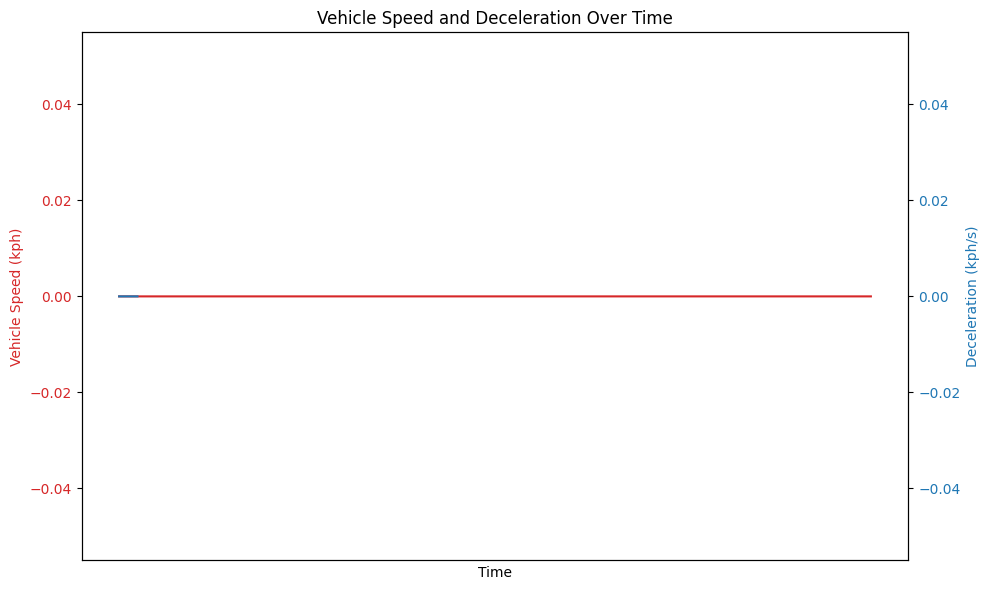

In [5]:

# Extract relevant signals for BrakePressed and VehicleSpeed
timestamps_brake = []
brake_pressed = []
timestamps_speed = []
vehicle_speeds = []

for frame in data:
    if frame['can_id'] == 168 and 'signals' in frame and 'BrakePressed' in frame['signals']:
        timestamps_brake.append(frame['timestamp'])
        brake_pressed.append(frame['signals']['BrakePressed'])
    if frame['can_id'] == 416 and 'signals' in frame and 'VehicleSpeed' in frame['signals']:
        timestamps_speed.append(frame['timestamp'])
        vehicle_speeds.append(frame['signals']['VehicleSpeed'])

# Creating DataFrames for each type of data
df_brakes = pd.DataFrame({
    'timestamp': pd.to_datetime(timestamps_brake),
    'BrakePressed': brake_pressed
})

df_speeds = pd.DataFrame({
    'timestamp': pd.to_datetime(timestamps_speed),
    'VehicleSpeed': vehicle_speeds
})

# Merging data on timestamps using nearest match
df = pd.merge_asof(df_brakes.sort_values('timestamp'), df_speeds.sort_values('timestamp'), on='timestamp', direction='nearest', tolerance=pd.Timedelta('1s'))

# Dropping any rows that didn't find a match within the tolerance
df.dropna(inplace=True)

# Calculating Deceleration
df['SpeedChange'] = df['VehicleSpeed'].diff().fillna(0)
df['Deceleration'] = -df['SpeedChange'] / df['timestamp'].diff().dt.total_seconds().fillna(1)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Vehicle Speed (kph)', color=color)
ax1.plot(df['timestamp'], df['VehicleSpeed'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Deceleration (kph/s)', color=color)
ax2.plot(df['timestamp'], df['Deceleration'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vehicle Speed and Deceleration Over Time')
fig.tight_layout()
plt.show()
